In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 检查版本
print('torch:', torch.__version__)
print('torchvision:', torchvision.__version__)
print('matplotlib:', matplotlib.__version__)
print('numpy:', numpy.__version__)

# 定义模型
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # 简化模型
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 初始化模型、损失函数和优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

# 加载数据
print('==> Loading data..')
train_data = torch.load('/train_mnist.pt')[:1000]  # 使用1000个训练样本
test_data = torch.load('/test_mnist.pt')[:200]  # 使用200个测试样本

# 减小批次大小
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True, num_workers=2)

classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

# 定义FGSM攻击方法
def fgsm(x, targets, net, epsilon):
    x.requires_grad = True
    outputs = net(x)
    net.zero_grad()
    loss = criterion(outputs, targets)
    loss.backward()
    data_grad = x.grad.data
    sign_data_grad = data_grad.sign()
    perturbation = epsilon * sign_data_grad

    # 确保扰动在合理范围内
    perturbation = torch.clamp(perturbation, -epsilon, epsilon)
    perturbed_image = x + perturbation

    # 确保对抗性样本的值在合理范围内
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image, perturbation, outputs

# 对抗性训练函数
def train_with_adversarial(epoch, train_loader, epsilon):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        # 正常前向传播
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # 生成对抗性样本并前向传播
        perturbed_inputs, perturbation, _ = fgsm(inputs, targets, net, epsilon)
        perturbed_outputs = net(perturbed_inputs)
        adv_loss = criterion(perturbed_outputs, targets)

        # 总损失 = 正常损失 + 对抗性损失
        total_loss = loss + adv_loss

        # 打印调试信息
        if batch_idx % 10 == 0:
            print(f'Batch {batch_idx}, Loss: {total_loss.item()}')

        total_loss.backward()  # 计算总损失的梯度
        optimizer.step()  # 更新模型参数

        train_loss += total_loss.item()
    return train_loss

# 测试函数
def test(epoch, test_loader):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100 * correct / total
    print('Epoch: {}, Accuracy: {:.6f}%'.format(epoch, acc))
    return test_loss, acc

# 训练和测试模型
train_losses = []
test_losses = []
num_epochs = 5
epsilon = 0.1  # 将 epsilon 设置为较小的值

for epoch in range(num_epochs):
    trl = train_with_adversarial(epoch, train_loader, epsilon)
    train_losses.append(trl)
    tstl, acc = test(epoch, test_loader)
    test_losses.append(tstl)

print('Accuracy of the network on the test images: %d %%' % (acc))

# 绘制训练损失和测试损失曲线
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.ylabel('Loss value')
plt.legend()
plt.show()

# 保存训练好的模型
torch.save({
    'epoch': epoch,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': criterion,
}, 'MLP_MNIST.pth')

# 加载训练好的模型
net = Classifier().to(device)
checkpoint = torch.load('MLP_MNIST.pth')
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

# 加载测试数据
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False, num_workers=2)

# 获取第一批测试样本
dataiter = iter(test_loader)
org_images, org_labels = next(dataiter)
org_images, org_labels = org_images.to(device), org_labels.to(device)

# 使用加载的模型进行预测
outputs = net(org_images)
_, predicted = torch.max(outputs.data, 1)

# 检查测试数据是否分类正确
def imshow(img, sz=5):
    npimg = img.cpu().numpy()
    plt.figure(figsize=(sz, sz))
    img_clip = np.clip(np.transpose(npimg, (1, 2, 0)), 0, 1)
    plt.imshow(img_clip)
    plt.show()

samples = []
samples_labels = []
samples_pred = []
selected = [16, 7, 13, 4, 29, 53, 0, 1]

for i in selected:
    samples.append(org_images[i])
    samples_labels.append(org_labels[i])
    samples_pred.append(predicted[i])

samples = torch.stack(samples)
samples_labels = torch.stack(samples_labels)
samples_pred = torch.stack(samples_pred)

imshow(torchvision.utils.make_grid(samples.cpu()))
print("Original labels:", samples_labels.cpu().numpy())
print("Predicted labels:", samples_pred.cpu().numpy())

# FGSM攻击
base_eps = 0.1  # 使用较小的 epsilon 值

for i in selected:
    image = org_images[i:i+1]
    targets = org_labels[i:i+1]
    eps = base_eps
    success = False
    while not success:
        perturbed_image, perturbation, outputs = fgsm(image, targets, net, eps)

        # 检查扰动是否有效
        print(f'Perturbation max: {perturbation.max()}, min: {perturbation.min()}')

        _, predicted = torch.max(outputs.data, 1)
        print(f'Original label: {targets.item()}, Predicted label: {outputs.argmax(1).item()}')

        if predicted.item() != targets.item():
            success = True
            print("===========================================================")
            imgs = [image[0].detach().cpu(), (perturbation[0] * (1/eps)).detach().cpu(), perturbed_image[0].detach().cpu()]

            imgs = torch.stack(imgs)
            imshow(torchvision.utils.make_grid(imgs.cpu(), nrow=3), 5)
            print("The first image is the original image.\n\
                  The second image is the perturbation.\n\
                  The third image is the perturbed image")
            print("The original class is '{}'.\n\
                  The predicted class of the perturbed image is '{}'".format(classes[targets.item()], classes[predicted.item()]))
        eps += base_eps


KeyboardInterrupt: 

torch: 2.2.1+cu121
torchvision: 0.17.1+cu121
matplotlib: 3.7.1
numpy: 1.25.2
==> Loading data..

Epoch: 0
Batch 0, Loss: 4.621305465698242
Batch 10, Loss: 4.608282089233398
Batch 20, Loss: 4.524601459503174
Batch 30, Loss: 4.505492210388184
Epoch: 0, Accuracy: 41.500000%

Epoch: 1
Batch 0, Loss: 4.487260818481445
Batch 10, Loss: 4.328004360198975
Batch 20, Loss: 4.310451507568359
Batch 30, Loss: 4.119318008422852
Epoch: 1, Accuracy: 61.500000%

Epoch: 2
Batch 0, Loss: 4.027672290802002
Batch 10, Loss: 3.993257999420166
Batch 20, Loss: 3.628152370452881
Batch 30, Loss: 3.705395221710205
Epoch: 2, Accuracy: 77.000000%

Epoch: 3
Batch 0, Loss: 3.041470527648926
Batch 10, Loss: 2.86140775680542
Batch 20, Loss: 2.66068696975708
Batch 30, Loss: 2.7357587814331055
Epoch: 3, Accuracy: 76.500000%

Epoch: 4
Batch 0, Loss: 2.30804443359375
Batch 10, Loss: 2.4319331645965576
Batch 20, Loss: 2.5270485877990723
Batch 30, Loss: 2.118086338043213
Epoch: 4, Accuracy: 81.000000%
Accuracy of the network 

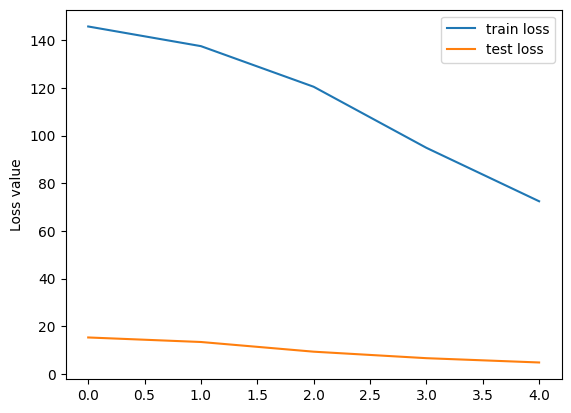

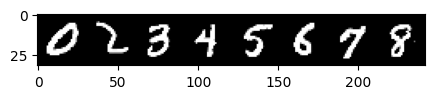

流式输出内容被截断，只能显示最后 5000 行内容。
Perturbation max: 3331.5, min: -3331.5
Original label: 0, Predicted label: 0
Perturbation max: 3331.60009765625, min: -3331.60009765625
Original label: 0, Predicted label: 0
Perturbation max: 3331.699951171875, min: -3331.699951171875
Original label: 0, Predicted label: 0
Perturbation max: 3331.800048828125, min: -3331.800048828125
Original label: 0, Predicted label: 0
Perturbation max: 3331.89990234375, min: -3331.89990234375
Original label: 0, Predicted label: 0
Perturbation max: 3332.0, min: -3332.0
Original label: 0, Predicted label: 0
Perturbation max: 3332.10009765625, min: -3332.10009765625
Original label: 0, Predicted label: 0
Perturbation max: 3332.199951171875, min: -3332.199951171875
Original label: 0, Predicted label: 0
Perturbation max: 3332.300048828125, min: -3332.300048828125
Original label: 0, Predicted label: 0
Perturbation max: 3332.39990234375, min: -3332.39990234375
Original label: 0, Predicted label: 0
Perturbation max: 3332.5, min: -333

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 检查版本
print('torch:', torch.__version__)
print('torchvision:', torchvision.__version__)
print('matplotlib:', matplotlib.__version__)
print('numpy:', numpy.__version__)

# 定义模型
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # 简化模型
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 初始化模型、损失函数和优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

# 加载数据
print('==> Loading data..')
train_data = torch.load('/train_mnist.pt')[:1000]  # 使用1000个训练样本
test_data = torch.load('/test_mnist.pt')[:200]  # 使用200个测试样本

# 减小批次大小
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True, num_workers=2)

classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

# 定义FGSM攻击方法
def fgsm(x, targets, net, epsilon):
    x.requires_grad = True
    outputs = net(x)
    net.zero_grad()
    loss = criterion(outputs, targets)
    loss.backward()
    data_grad = x.grad.data
    sign_data_grad = data_grad.sign()
    perturbation = epsilon * sign_data_grad

    # 确保扰动在合理范围内
    perturbation = torch.clamp(perturbation, -epsilon, epsilon)
    perturbed_image = x + perturbation

    # 确保对抗性样本的值在合理范围内
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image, perturbation, outputs

# 对抗性训练函数
def train_with_adversarial(epoch, train_loader, epsilon):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        # 正常前向传播
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # 生成对抗性样本并前向传播
        perturbed_inputs, perturbation, _ = fgsm(inputs, targets, net, epsilon)
        perturbed_outputs = net(perturbed_inputs)
        adv_loss = criterion(perturbed_outputs, targets)

        # 总损失 = 正常损失 + 对抗性损失
        total_loss = loss + adv_loss

        # 打印调试信息
        if batch_idx % 10 == 0:
            print(f'Batch {batch_idx}, Loss: {total_loss.item()}')

        total_loss.backward()  # 计算总损失的梯度
        optimizer.step()  # 更新模型参数

        train_loss += total_loss.item()
    return train_loss

# 测试函数
def test(epoch, test_loader):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100 * correct / total
    print('Epoch: {}, Accuracy: {:.6f}%'.format(epoch, acc))
    return test_loss, acc

# 训练和测试模型
train_losses = []
test_losses = []
num_epochs = 5
epsilon = 0.1  # 将 epsilon 设置为较小的值

for epoch in range(num_epochs):
    trl = train_with_adversarial(epoch, train_loader, epsilon)
    train_losses.append(trl)
    tstl, acc = test(epoch, test_loader)
    test_losses.append(tstl)

print('Accuracy of the network on the test images: %d %%' % (acc))

# 绘制训练损失和测试损失曲线
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.ylabel('Loss value')
plt.legend()
plt.show()

# 保存训练好的模型
torch.save({
    'epoch': epoch,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': criterion,
}, 'MLP_MNIST.pth')

# 加载训练好的模型
net = Classifier().to(device)
checkpoint = torch.load('MLP_MNIST.pth')
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

# 加载测试数据
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False, num_workers=2)

# 获取第一批测试样本
dataiter = iter(test_loader)
org_images, org_labels = next(dataiter)
org_images, org_labels = org_images.to(device), org_labels.to(device)

# 使用加载的模型进行预测
outputs = net(org_images)
_, predicted = torch.max(outputs.data, 1)

# 检查测试数据是否分类正确
def imshow(img, sz=5):
    npimg = img.cpu().numpy()
    plt.figure(figsize=(sz, sz))
    img_clip = np.clip(np.transpose(npimg, (1, 2, 0)), 0, 1)
    plt.imshow(img_clip)
    plt.show()

samples = []
samples_labels = []
samples_pred = []
selected = [16, 7, 13, 4, 29, 53, 0, 1]

for i in selected:
    samples.append(org_images[i])
    samples_labels.append(org_labels[i])
    samples_pred.append(predicted[i])

samples = torch.stack(samples)
samples_labels = torch.stack(samples_labels)
samples_pred = torch.stack(samples_pred)

imshow(torchvision.utils.make_grid(samples.cpu()))
print("Original labels:", samples_labels.cpu().numpy())
print("Predicted labels:", samples_pred.cpu().numpy())

# FGSM攻击
base_eps = 0.1  # 使用较小的 epsilon 值

for i in selected:
    image = org_images[i:i+1]
    targets = org_labels[i:i+1]
    eps = base_eps
    success = False
    while not success:
        perturbed_image, perturbation, outputs = fgsm(image, targets, net, eps)

        # 检查扰动是否有效
        print(f'Perturbation max: {perturbation.max()}, min: {perturbation.min()}')

        _, predicted = torch.max(outputs.data, 1)
        print(f'Original label: {targets.item()}, Predicted label: {outputs.argmax(1).item()}')

        if predicted.item() != targets.item():
            success = True
            print("===========================================================")
            imgs = [image[0].detach().cpu(), (perturbation[0] * (1/eps)).detach().cpu(), perturbed_image[0].detach().cpu()]

            imgs = torch.stack(imgs)
            imshow(torchvision.utils.make_grid(imgs.cpu(), nrow=3), 5)
            print("The first image is the original image.\n\
                  The second image is the perturbation.\n\
                  The third image is the perturbed image")
            print("The original class is '{}'.\n\
                  The predicted class of the perturbed image is '{}'".format(classes[targets.item()], classes[predicted.item()]))
        eps += base_eps
